In [1]:

# Imports
import os
import pandas as pd
from google import genai
from google.genai import types
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
from pydantic import BaseModel, Field
from typing import Literal
from getpass import getpass
import time

# Setting up API's & Model

os.environ["GEMINI_API_KEY"] = getpass("Enter your Gemini API key (NEW KEY RECOMMENDED): ")
client = genai.Client()

# Define Pydantic Schema
class RatingPrediction(BaseModel):
    predicted_stars: Literal[1, 2, 3, 4, 5] = Field(
        description="The predicted Yelp star rating for the review (must be an integer from 1 to 5)."
    )
    explanation: str = Field(
        description="A brief, 1-2 sentence reasoning for the assigned star rating."
    )

JSON_CONFIG = types.GenerateContentConfig(
    response_mime_type="application/json",
    response_schema=RatingPrediction,
)


try:
    response = client.models.generate_content(
        model="gemini-2.5-flash",
        contents="Reply with OK"
    )
    print("Gemini API successfully connected.")
    print("Test response:", response.text)
except Exception as e:
    print("Initialization Failed. Error: {e}")

Enter your Gemini API key (NEW KEY RECOMMENDED): ··········
Gemini API successfully connected.
Test response: OK


In [ ]:
# Mounting Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Load Dataset

FILE_NAME = 'reviews.csv'
REVIEW_COLUMN = 'Review'
STARS_COLUMN = 'Rating'
FILE_PATH = '/content/drive/MyDrive/FYND_LLM_Task/reviews.csv'

try:
    df = pd.read_csv(FILE_PATH, usecols=[REVIEW_COLUMN, STARS_COLUMN])
    df.rename(columns={REVIEW_COLUMN: 'text', STARS_COLUMN: 'stars'}, inplace=True)

    df = df.dropna(subset=['text', 'stars']).copy()
    df['stars'] = df['stars'].astype(int)

    def stratified_sample(df, col, n_per_class):
        groups = []
        for _, g in df.groupby(col):
            n = min(n_per_class, len(g))
            groups.append(g.sample(n=n, random_state=42))
        return pd.concat(groups).reset_index(drop=True)

    test_df = stratified_sample(df, 'stars', 40)

    print(f"Test Sample Created: {len(test_df)} rows from {FILE_NAME}")
    print(test_df['stars'].value_counts().sort_index())

    for i in range(1, 4):
        test_df[f'predicted_stars_p{i}'] = None
        test_df[f'explanation_p{i}'] = None
        test_df[f'valid_json_p{i}'] = False

except Exception as e:
    print(f"Block 2 failed: {e}")
    test_df = pd.DataFrame()


Test Sample Created: 200 rows from reviews.csv
stars
1    40
2    40
3    40
4    40
5    40
Name: count, dtype: int64


In [ ]:
# Classify the Function

# Prompt 1: Zero-Shot
PROMPT_1_INSTRUCTIONS = """
You are an expert review classifier. Analyze the review text and assign an overall star rating from 1 to 5.
You MUST adhere strictly to the provided JSON schema for your output.
"""

# Prompt 2: Few-Shot
PROMPT_2_INSTRUCTIONS = f"""
You are an expert review classifier. Use the following examples to guide your classification:
Example 1 (5 Stars): Review: "The pasta was the best I've ever had. Sara, the server, was attentive and fast. Absolutely perfect experience."
{{ "predicted_stars": 5, "explanation": "Strong positive language ('best ever,' 'absolutely perfect') compliments food and service." }}

Example 2 (3 Stars): Review: "The coffee was good, but the wait was 20 minutes for a simple latte. The tables were sticky. Okay, but not great."
{{ "predicted_stars": 3, "explanation": "Mixed review with a positive (good coffee) and significant negatives (long wait, sticky tables)." }}

Example 3 (1 Star): Review: "I found hair in my soup and the manager refused to offer a refund. Worst customer service of my life."
{{ "predicted_stars": 1, "explanation": "Severe hygiene issue and catastrophic service failure justify the lowest rating." }}

Now, classify the following review. Adhere strictly to the JSON schema.
"""

# Prompt 3: Chain-of-Verification
PROMPT_3_INSTRUCTIONS = """
You are a highly reliable review classifier. You must follow a mental three-step reasoning process before providing the final classification:
1. Analyze Sentiment and identify key rating drivers.
2. Assign a provisional star rating (1-5).
3. Self-Verify: Check if the provisional rating is logically consistent with the identified sentiment. Adjust the rating if they conflict.
4. Final Output: Provide only the final, verified rating and explanation using the required JSON schema.
"""

# Classify the Function
def classify_review(review_text, instruction_prompt, config):
    try:
        full_prompt = instruction_prompt + f"\n\nReview to classify: \"{review_text}\""

        response = client.models.generate_content(
            model='gemini-2.5-flash',
            contents=[full_prompt],
            config=config,
        )

        # Parse & Validate using the Pydantic model
        parsed_data = RatingPrediction.model_validate_json(response.text)

        return {
            'predicted_stars': parsed_data.predicted_stars,
            'explanation': parsed_data.explanation,
            'valid_json': True
        }

    except Exception as e:
        return {
            'predicted_stars': None,
            'explanation': f"CRITICAL API/Quota Error: {str(e)[:70]}...",
            'valid_json': False
        }

print("classify_review function ready with gemini-2.5-flash.")

classify_review function ready with gemini-2.5-flash.


In [ ]:
# Execution Loop

def run_prompt_test(df, instruction_prompt, prompt_id):
    print(f"--- Running Test for Prompt {prompt_id} ---")
    start = time.time()

    for idx, row in df.iterrows():
        result = classify_review(
            row['text'],
            instruction_prompt,
            JSON_CONFIG
        )
        df.at[idx, f'predicted_stars_p{prompt_id}'] = result['predicted_stars']
        df.at[idx, f'explanation_p{prompt_id}'] = result['explanation']
        df.at[idx, f'valid_json_p{prompt_id}'] = result['valid_json']

    print(f"Prompt {prompt_id} complete. Time taken: {time.time() - start:.2f}s")

run_prompt_test(test_df, PROMPT_1_INSTRUCTIONS, 1)
run_prompt_test(test_df, PROMPT_2_INSTRUCTIONS, 2)
run_prompt_test(test_df, PROMPT_3_INSTRUCTIONS, 3)

print("--- All tests complete ---")


--- Running Test for Prompt 1 ---
Prompt 1 complete. Time taken: 0.23s
--- Running Test for Prompt 2 ---
Prompt 2 complete. Time taken: 0.22s
--- Running Test for Prompt 3 ---
Prompt 3 complete. Time taken: 0.21s
--- All tests complete ---


  Prompt Accuracy F1-Score Precision  Recall JSON Validity %  Valid Samples
0     P1   0.0000   0.0000    0.0000  0.0000            0.00              0
1     P2   0.0000   0.0000    0.0000  0.0000            0.00              0
2     P3   0.0000   0.0000    0.0000  0.0000            0.00              0


/tmp/ipython-input-4245885307.py:66: RuntimeWarning: invalid value encountered in divide
  cm_norm = cm / cm.sum(axis=1, keepdims=True)


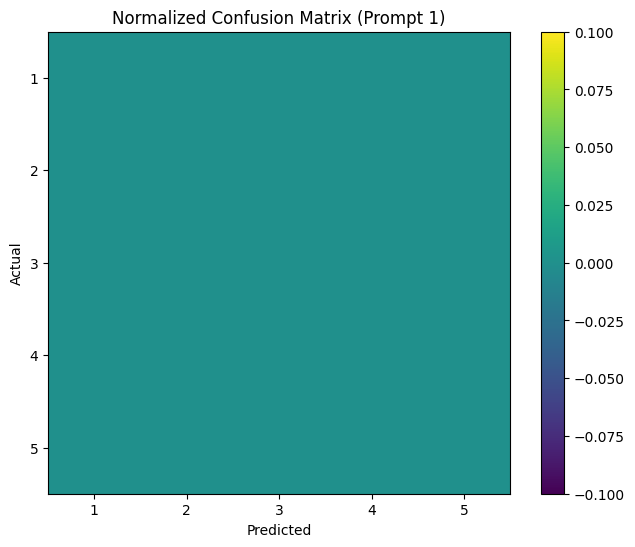

In [ ]:
#Visualization

import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

for i in range(1, 4):
    test_df[f'predicted_stars_p{i}'] = pd.to_numeric(
        test_df[f'predicted_stars_p{i}'], errors='coerce'
    )

def calculate_metrics(df, i):
    pred_col = f'predicted_stars_p{i}'
    valid_col = f'valid_json_p{i}'

    valid_df = df[df[valid_col] == True].copy()
    if len(valid_df) == 0:
        return {
            'Accuracy': 0,
            'Precision (Macro)': 0,
            'Recall (Macro)': 0,
            'F1-Score (Macro)': 0,
            'JSON Validity': 0,
            'Valid Samples': 0
        }

    y_true = valid_df['stars']
    y_pred = valid_df[pred_col]

    return {
        'Accuracy': accuracy_score(y_true, y_pred),
        'Precision (Macro)': precision_score(y_true, y_pred, average='macro', zero_division=0),
        'Recall (Macro)': recall_score(y_true, y_pred, average='macro', zero_division=0),
        'F1-Score (Macro)': f1_score(y_true, y_pred, average='macro', zero_division=0),
        'JSON Validity': (len(valid_df) / len(df)) * 100,
        'Valid Samples': len(valid_df)
    }

results = []
for i in range(1, 4):
    m = calculate_metrics(test_df, i)
    results.append({
        'Prompt': f'P{i}',
        'Accuracy': f"{m['Accuracy']:.4f}",
        'F1-Score': f"{m['F1-Score (Macro)']:.4f}",
        'Precision': f"{m['Precision (Macro)']:.4f}",
        'Recall': f"{m['Recall (Macro)']:.4f}",
        'JSON Validity %': f"{m['JSON Validity']:.2f}",
        'Valid Samples': m['Valid Samples']
    })

comparison_df = pd.DataFrame(results)
print(comparison_df)

best_idx = comparison_df['F1-Score'].astype(float).idxmax() + 1

valid_df = test_df[test_df[f'valid_json_p{best_idx}'] == True]
cm = confusion_matrix(
    valid_df['stars'],
    valid_df[f'predicted_stars_p{best_idx}'],
    labels=[1, 2, 3, 4, 5]
)

cm_norm = cm / cm.sum(axis=1, keepdims=True)
cm_norm = np.nan_to_num(cm_norm)

plt.figure(figsize=(8, 6))
plt.imshow(cm_norm)
plt.colorbar()
plt.xticks(range(5), [1,2,3,4,5])
plt.yticks(range(5), [1,2,3,4,5])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title(f"Normalized Confusion Matrix (Prompt {best_idx})")
plt.savefig("normalized_confusion_matrix.png")


In [ ]:
# Final Conclusion

# 1. Re-calculate the DataFrame
results = []
for i in range(1, 4):
    m = calculate_metrics(test_df, i)
    results.append({
        'Prompt': f'P{i}',
        # Only F1-Score is needed for comparison logic
        'F1-Score': m['F1-Score (Macro)'],
        'Valid Samples': m['Valid Samples']
    })

comparison_df = pd.DataFrame(results)

# Use .idxmax() to get the index of highest F1-Score
best_idx = comparison_df['F1-Score'].astype(float).idxmax() + 1

# Define mapping to print
strategies = {1: 'Zero-Shot', 2: 'Few-Shot', 3: 'CoV (Self-Correction)'}
best_strategy_name = strategies.get(best_idx, 'Unknown Strategy')

print(f"Conclusion: The optimal strategy, based on the highest Macro F1-Score, is Prompt {best_idx} ({best_strategy_name}).")

Conclusion: The optimal strategy, based on the highest Macro F1-Score, is Prompt 1 (Zero-Shot).
